# YNet - Dataset 5:

Data from Experiment (2), Mitochondria = Cit1-mCherry 

### Importing utilities:

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import os
from pathlib import Path
import skimage.external.tifffile as tiff

from common import Statistics, dataset_source
from resources.conv_learner import *
from resources.plots import *
from pprint import pprint
import matplotlib.pyplot as plt
%matplotlib inline

#### Setting up variables

In [3]:
PATH = "datasets/yeast_v5.3/"
data_path = Path(PATH)

In [4]:
CLASSES = ('WT', 'mfb1KO', 'mmr1KO','mmm1KO', 'num1KO','mfb1KO_mmr1KO')
NUM_CLASSES = len(CLASSES)
BATCH_SIZE = 64
SIZE = 200

#### Calculating normalization statistics

Note that we are setting up train & val data, as well as test. Within test, we are here including a mutant cell type that the model never trains on. The idea is to use to the feature space developed during training to evaluate novel cell types by similarity to the landmarks that the model was trained on. 

In [5]:
stats_name = "yeast_v5.3_per_class.dict"
classes = Statistics.source_class(data_path)

train_val = zip(classes['train'], classes['val'])
# Xtest = zip(classes['test'])
 
main_stats = Statistics.per_class(train_val, save_name=stats_name)
# test_stats = Statistics.per_class(Xtest, save_name=stats_name)

working on: datasets\yeast_v5.3\train\01_mfb1KO
working on: datasets\yeast_v5.3\val\01_mfb1KO
working on: datasets\yeast_v5.3\train\01_mmm1KO
working on: datasets\yeast_v5.3\val\01_mmm1KO
working on: datasets\yeast_v5.3\train\01_mmr1KO
working on: datasets\yeast_v5.3\val\01_mmr1KO
working on: datasets\yeast_v5.3\train\01_num1KO
working on: datasets\yeast_v5.3\val\01_num1KO
working on: datasets\yeast_v5.3\train\01_WT
working on: datasets\yeast_v5.3\val\01_WT
working on: datasets\yeast_v5.3\train\02_mfb1KO
working on: datasets\yeast_v5.3\val\02_mfb1KO
working on: datasets\yeast_v5.3\train\02_mmr1KO
working on: datasets\yeast_v5.3\val\02_mmr1KO
working on: datasets\yeast_v5.3\train\02_mmr1KO-mfb1KO
working on: datasets\yeast_v5.3\val\02_mmr1KO-mfb1KO
working on: datasets\yeast_v5.3\train\02_WT
working on: datasets\yeast_v5.3\val\02_WT


In [6]:
for keys in main_stats.keys():
    print(f"{keys}: \t \t \t {main_stats[keys]}")

01_mfb1KO: 	 	 	 (array([0.02112, 0.00447]), array([0.00145, 0.00144]))
01_mmm1KO: 	 	 	 (array([0.021  , 0.00422]), array([0.00146, 0.00192]))
01_mmr1KO: 	 	 	 (array([0.02116, 0.00486]), array([0.00156, 0.00197]))
01_num1KO: 	 	 	 (array([0.02098, 0.00502]), array([0.00146, 0.00212]))
01_WT: 	 	 	 (array([0.0211 , 0.00456]), array([0.00151, 0.00132]))
02_mfb1KO: 	 	 	 (array([0.00793, 0.00491]), array([0.00076, 0.00171]))
02_mmr1KO: 	 	 	 (array([0.00798, 0.005  ]), array([0.00075, 0.002  ]))
02_mmr1KO-mfb1KO: 	 	 	 (array([0.0079 , 0.00485]), array([0.00075, 0.00159]))
02_WT: 	 	 	 (array([0.00794, 0.00479]), array([0.00076, 0.00151]))


In [ ]:
main_stats_Y = {lbl2index[key][1]: val for key, val in main_stats.items()}
print(main_stats_Y)

In [ ]:
for keys in test_stats.keys():
    print(f"{keys}: \t \t \t {test_stats[keys]}")

## Defining datasets:

In [6]:
def tfms_for_test(stats, sz):
    test_norm = Normalize(stats)
    test_denorm = Denormalize(stats)
    val_crop = CropType.NO
    test_tfms = image_gen(test_norm, test_denorm,sz, crop_type=val_crop)
    return test_tfms

In [7]:
def get_data(path: str, sz, bs):
    create, lbl2index, lbl2index_test = ImageClassifierData.prepare_from_path(path, val_name='val', bs=bs, num_workers=8)
    main_stats_X = {lbl2index[key][0]: val for key, val in main_stats.items()}
    tfms = tfms_from_stats(main_stats_X, sz, aug_tfms=[RandomDihedral()], pad=sz//8)
    
#     test_stats_X= {lbl2index_test[key]: val for key, val in lbl2index_test.items()}
#     test_tfms = tfms_for_test(test_stats_X,sz)
#     tfms += (test_tfms, )
    
    print('\n class to index mapping:\n',lbl2index)
    return create(tfms)

In [8]:
data = get_data(PATH,SIZE,BATCH_SIZE)


 class to index mapping:
 {'01_WT': [0, 0, 'WT'], '01_mfb1KO': [1, 1, 'mfb1KO'], '01_mmm1KO': [2, 2, 'mmm1KO'], '01_mmr1KO': [3, 3, 'mmr1KO'], '01_num1KO': [4, 4, 'num1KO'], '02_WT': [5, 0, 'WT'], '02_mfb1KO': [6, 1, 'mfb1KO'], '02_mmr1KO': [7, 3, 'mmr1KO'], '02_mmr1KO-mfb1KO': [8, 5, 'mmr1KO-mfb1KO']}


In [9]:
x, y = next(iter(data.trn_dl))

In [10]:
print(len(data.val_dl.dataset.y))
print(len(data.trn_dl.dataset.y))
# print(y)

315
1755


### Inspect loaded data:

Displaying the same image with and without normalization.

In [ ]:
# specify which image-index
idx = 6

# loading it from GPU to CPU
xx = x[idx].cpu().numpy().copy()
yy = y[idx]
# showing the image
#
#sp.axis('Off')
#sp.set_title("Norm", fontsize=11)
figure, _ ,_ = tiff.imshow(np.sum(xx, axis=0))
figure.set_size_inches(6,6)
figure.add_subplot(111)

# figure2, _, _ = tiff.imshow(np.sum(data.trn_ds.denorm(xx,yy).squeeze() * 65536, axis=2)) # not very elegant atm. 
# figure2.set_size_inches(6,6)
print(yy)

# Training setup

In [11]:
torch.cuda.is_available()

True

## ResNet_with_Batchnorm

Defining network architecture. 

In [9]:
class BnLayer(nn.Module):
    def __init__(self, ni, nf, stride=2, kernel_size=3):
        super().__init__()
        self.conv = nn.Conv2d(ni, nf, kernel_size=kernel_size, stride=stride,
                              bias=False, padding=1)
        self.a = nn.Parameter(torch.zeros(nf,1,1))
        self.m = nn.Parameter(torch.ones(nf,1,1))
        
    def forward(self, x):
        x = F.relu(self.conv(x))
        x_chan = x.transpose(0,1).contiguous().view(x.size(1), -1)
        if self.training:
            self.means = x_chan.mean(1)[:,None,None]
            self.stds  = x_chan.std (1)[:,None,None]
        return (x-self.means) / self.stds *self.m + self.a

In [10]:
class ResnetLayer(BnLayer):
    def forward(self, x): return x + super().forward(x)

In [11]:
class Resnet(nn.Module):
    def __init__(self, layers, c):
        super().__init__()
        self.conv1 = nn.Conv2d(2, 10, kernel_size=5, stride=1, padding=2)
        self.layers = nn.ModuleList([BnLayer(layers[i], layers[i+1])
            for i in range(len(layers) - 1)])
        self.layers2 = nn.ModuleList([ResnetLayer(layers[i+1], layers[i + 1], 1)
            for i in range(len(layers) - 1)])
        self.layers3 = nn.ModuleList([ResnetLayer(layers[i+1], layers[i + 1], 1)
            for i in range(len(layers) - 1)])
        self.out = nn.Linear(layers[-1], c)
        
    def forward(self, x):
        x = self.conv1(x)
        for l,l2,l3 in zip(self.layers, self.layers2, self.layers3):
            x = l3(l2(l(x)))
        x = F.adaptive_max_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        return F.log_softmax(self.out(x), dim=-1)

In [12]:
wd=1e-5 # weight-decay/L2 regularization 

In [23]:
learn = ConvLearner.from_model_data(Resnet([10, 20, 40, 80, 160], 6), data)

In [17]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 2, 200, 200]),
                           ('output_shape', [-1, 10, 200, 200]),
                           ('trainable', True),
                           ('nb_params', 510)])),
             ('Conv2d-2',
              OrderedDict([('input_shape', [-1, 10, 200, 200]),
                           ('output_shape', [-1, 20, 100, 100]),
                           ('trainable', True),
                           ('nb_params', 1800)])),
             ('BnLayer-3',
              OrderedDict([('input_shape', [-1, 10, 200, 200]),
                           ('output_shape', [-1, 20, 100, 100]),
                           ('nb_params', 0)])),
             ('Conv2d-4',
              OrderedDict([('input_shape', [-1, 20, 100, 100]),
                           ('output_shape', [-1, 20, 100, 100]),
                           ('trainable', True),
                           ('nb_params', 3600)])),
             ('ResnetLayer-5',
     

In [22]:
%time learn.fit(1e-2, 8, cycle_len=1, wds=wd)

EPOCH 0 ---------------------------------------- STEP 4                                                                                                                                                              
mean: [18.07143 20.      10.53571 29.28571  3.78571 15.57143]
stdev: [4.94923 5.92814 4.71686 5.554   2.60983 4.41935]

[WT]: 21.43%
[mfb1KO]: 5.714%
[mmm1KO]: 97.14%
[mmr1KO]: 87.14%
[num1KO]:  0.0%
[mmr1KO-mfb1KO]:  0.0%
epoch      trn_loss   val_loss   accuracy   
    0      1.443386   2.038759   0.361905  
EPOCH 1 ---------------------------------------- STEP 5                                                                                                                                                              
mean: [18.32143 19.82143 10.60714 28.82143  3.82143 15.75   ]
stdev: [4.44854 5.14124 3.0159  5.20339 1.89083 3.15804]

[WT]: 67.14%
[mfb1KO]:  0.0%
[mmm1KO]: 91.43%
[mmr1KO]: 88.57%
[num1KO]:  0.0%
[mmr1KO-mfb1KO]:  0.0%
    1      1.4334     1.888772   0.447

[array([1.90683]), 0.4222222195731269]

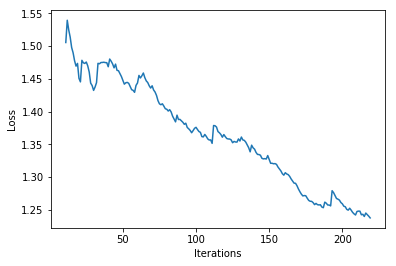

In [23]:
f = plt.figure()
x = learn.sched.plot_loss()
plt.ylabel('Loss')
plt.xlabel('Iterations')
plt.show()

#### Run some more cylces - error & accuracy should continuously improve

Note: cycle len = number of epochs per cycle

In [24]:
%time learn.fit(1e-2, 8, wds=wd, cycle_len=10, use_clr=(20,8, 0.95, 0.85))

EPOCH 0 ---------------------------------------- STEP 12                                                                                                                                                             
mean: [18.14286 19.60714 10.75    29.       3.85714 15.46429]
stdev: [4.56473 4.71577 4.21413 7.13643 2.72179 4.79942]

[WT]: 71.43%
[mfb1KO]: 24.29%
[mmm1KO]: 97.14%
[mmr1KO]: 80.0%
[num1KO]: 28.57%
[mmr1KO-mfb1KO]: 28.57%
epoch      trn_loss   val_loss   accuracy   
    0      1.098387   1.234975   0.561905  
EPOCH 1 ---------------------------------------- STEP 13                                                                                                                                                             
mean: [18.42857 19.64286 10.60714 29.07143  3.89286 15.57143]
stdev: [5.29439 5.70222 3.74489 6.62748 3.12066 4.60922]

[WT]: 55.71%
[mfb1KO]: 62.86%
[mmm1KO]: 97.14%
[mmr1KO]: 62.86%
[num1KO]: 51.43%
[mmr1KO-mfb1KO]:  0.0%
    1      1.095706   1.263743   0.

[num1KO]: 51.43%
[mmr1KO-mfb1KO]: 31.43%
    33     0.577587   0.752282   0.720635  
EPOCH 34 ---------------------------------------- STEP 46                                                                                                                                                            
mean: [18.28571 19.71429 10.60714 29.03571  3.82143 15.60714]
stdev: [4.56584 4.34952 3.26605 6.95127 2.0538  4.38617]

[WT]: 85.71%
[mfb1KO]: 74.29%
[mmm1KO]: 100.0%
[mmr1KO]: 84.29%
[num1KO]: 77.14%
[mmr1KO-mfb1KO]: 48.57%
    34     0.557136   0.521601   0.793651  
EPOCH 35 ---------------------------------------- STEP 47                                                                                                                                                            
mean: [18.28571 19.64286 10.57143 29.14286  3.92857 15.67857]
stdev: [4.68933 4.79743 3.32124 6.07521 2.3744  4.70603]

[WT]: 71.43%
[mfb1KO]: 81.43%
[mmm1KO]: 97.14%
[mmr1KO]: 88.57%
[num1KO]: 42.86%
[mmr1KO-mfb1KO]: 

[mmm1KO]: 100.0%
[mmr1KO]: 97.14%
[num1KO]: 65.71%
[mmr1KO-mfb1KO]: 51.43%
    67     0.358496   0.523047   0.847619  
EPOCH 68 ---------------------------------------- STEP 80                                                                                                                                                            
mean: [18.25    19.71429 10.92857 29.10714  3.82143 15.57143]
stdev: [4.06751 4.16497 5.47676 5.1014  2.47925 3.02877]

[WT]: 81.43%
[mfb1KO]: 92.86%
[mmm1KO]: 94.29%
[mmr1KO]: 91.43%
[num1KO]: 85.71%
[mmr1KO-mfb1KO]: 57.14%
    68     0.347844   0.393491   0.853968  
EPOCH 69 ---------------------------------------- STEP 81                                                                                                                                                            
mean: [18.46429 19.67857 10.57143 28.85714  3.82143 15.71429]
stdev: [5.71015 3.97361 3.80252 4.61143 2.47925 3.27171]

[WT]: 85.71%
[mfb1KO]: 90.0%
[mmm1KO]: 100.0%
[mmr1KO]: 94.29%
[

[array([0.45254]), 0.8349206404080467]

In [ ]:
%time learn.fit(1e-3, 2, wds=wd, cycle_len=20, use_clr=(20,8, 0.95, 0.85))

In [25]:
%time learn.fit(1e-3, 2, wds=wd, cycle_len=20, use_clr=(20,8, 0.95, 0.85), best_save_name='YNet_Res_v5.3')

EPOCH 0 ---------------------------------------- STEP 92                                                                                                                                                             
mean: [18.32143 20.      10.39286 28.78571  3.82143 15.96429]
stdev: [4.35114 5.8554  3.60891 4.98109 2.47925 4.35465]

[WT]: 77.14%
[mfb1KO]: 92.86%
[mmm1KO]: 100.0%
[mmr1KO]: 98.57%
[num1KO]: 80.0%
[mmr1KO-mfb1KO]: 57.14%
epoch      trn_loss   val_loss   accuracy   
    0      0.251132   0.436505   0.860317  
EPOCH 1 ---------------------------------------- STEP 93                                                                                                                                                             
mean: [18.32143 19.78571 10.53571 29.       3.75    15.60714]
stdev: [5.25121 4.08269 3.7842  4.98569 2.65417 4.27901]

[WT]: 88.57%
[mfb1KO]: 92.86%
[mmm1KO]: 100.0%
[mmr1KO]: 92.86%
[num1KO]: 82.86%
[mmr1KO-mfb1KO]: 62.86%
input an addition to the save path

EPOCH 32 ---------------------------------------- STEP 124                                                                                                                                                           
mean: [18.46429 19.71429 10.53571 29.03571  3.92857 15.53571]
stdev: [4.86593 5.81167 3.14509 4.39547 2.67166 3.67892]

[WT]: 81.43%
[mfb1KO]: 94.29%
[mmm1KO]: 100.0%
[mmr1KO]: 90.0%
[num1KO]: 85.71%
[mmr1KO-mfb1KO]: 80.0%
    32     0.221943   0.341816   0.885714  
EPOCH 33 ---------------------------------------- STEP 125                                                                                                                                                           
mean: [18.14286 20.10714 10.57143 28.92857  3.78571 15.67857]
stdev: [3.48173 5.52487 4.32128 5.72544 2.95631 3.8271 ]

[WT]: 90.0%
[mfb1KO]: 81.43%
[mmm1KO]: 97.14%
[mmr1KO]: 88.57%
[num1KO]: 88.57%
[mmr1KO-mfb1KO]: 68.57%
    33     0.217807   0.355324   0.860317  
EPOCH 34 ----------------------------

[array([0.30234]), 0.9047619060864525]

## Analysis/Model evaluation

This is one of the major areas that needs improvement in our workflow. The tools we have so far (confusion matrix and manual inpsection of images) are essential but definitely not sufficient to ensure that our model learns something biologicaly relevant. Ideas are welcome!

### ...after training 

In [24]:
## Load model:
learn.load('YNet_Res_v5.3')

In [25]:
%time learn.fit(1e-3, 2, wds=wd, cycle_len=20, use_clr=(20,8, 0.95, 0.85))

EPOCH 0 ---------------------------------------- STEP 2                                                                                                                                                              
mean: [18.35714 20.32143 10.46429 28.82143  3.82143 15.57143]
stdev: [5.17007 5.54239 3.63005 5.65719 2.20476 4.49943]

[WT]: 67.14%
[mfb1KO]: 80.0%
[mmm1KO]: 97.14%
[mmr1KO]: 91.43%
[num1KO]: 74.29%
[mmr1KO-mfb1KO]: 40.0%
epoch      trn_loss   val_loss   accuracy   
    0      0.642669   0.737301   0.765079  
EPOCH 1 ---------------------------------------- STEP 3                                                                                                                                                              
mean: [18.25    19.64286 10.75    28.92857  4.03571 15.5    ]
stdev: [5.41575 4.33601 4.59522 5.69416 2.78365 4.60202]

[WT]: 84.29%
[mfb1KO]: 91.43%
[mmm1KO]: 94.29%
[mmr1KO]: 85.71%
[num1KO]: 71.43%
[mmr1KO-mfb1KO]: 62.86%
    1      0.498661   0.466042   0.

KeyboardInterrupt: 

In [26]:
log_preds, y = learn.TTA(n_aug=1) # run predictions with TTA

### Confusion matrix

[[58  1  0  1  1  5]
 [ 1 64  0  1  0  1]
 [ 0  0 35  0  0  0]
 [ 4  2  0 64  0  4]
 [ 0  0  0  0 33  0]
 [ 7  3  0  4  1 25]]


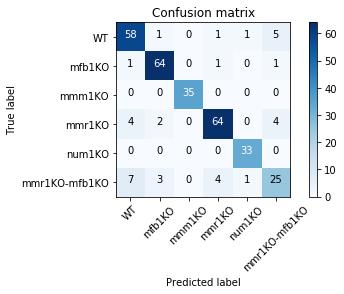

In [27]:
# Plot confusion matrix 
log_preds_mean = np.mean(log_preds, axis=0)
preds = np.argmax(log_preds_mean, axis=1)
cm = confusion_matrix(preds,y)
plot_confusion_matrix(cm, data.classes)

In [29]:
def temp_embedding(layer, inp, outp):
    tmp = inp[0]
    embedding.append(tmp)

In [32]:
# getting a target layer module:
layer = learn.models.model._modules.get('out')

# # registering the hook
hook = layer.register_forward_hook(temp_embedding)

# # running learn.predict and collecting all activations from the target layer
embedding = []
log_preds, y = learn.predict_with_targs('trn')
hook.remove()

In [33]:
embs_trn = np.vstack(to_np(embedding))
y_trn = y

# embs_val = np.vstack(to_np(embedding))
# y_val = y

# embs_test = np.vstack(to_np(embedding))
# y_test = y

In [34]:
print(embs_trn.shape)
print(embs_val.shape)
# print(embs_test.shape)

(1755, 160)
(315, 160)


In [35]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [36]:
# running PCA on embeddings
pca = []
n_components = 50
pca = PCA(n_components)

trn_pca_result = pca.fit_transform(embs_trn)
val_pca_result = pca.transform(embs_val)
# test_pca_result = pca.transform(embs_test)

In [37]:
# running TSNE on embeddings

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(embs_trn)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1755 samples in 0.024s...
[t-SNE] Computed neighbors for 1755 samples in 0.821s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1755
[t-SNE] Computed conditional probabilities for sample 1755 / 1755
[t-SNE] Mean sigma: 2.544128
[t-SNE] KL divergence after 250 iterations with early exaggeration: 70.496613
[t-SNE] Error after 300 iterations: 1.537636


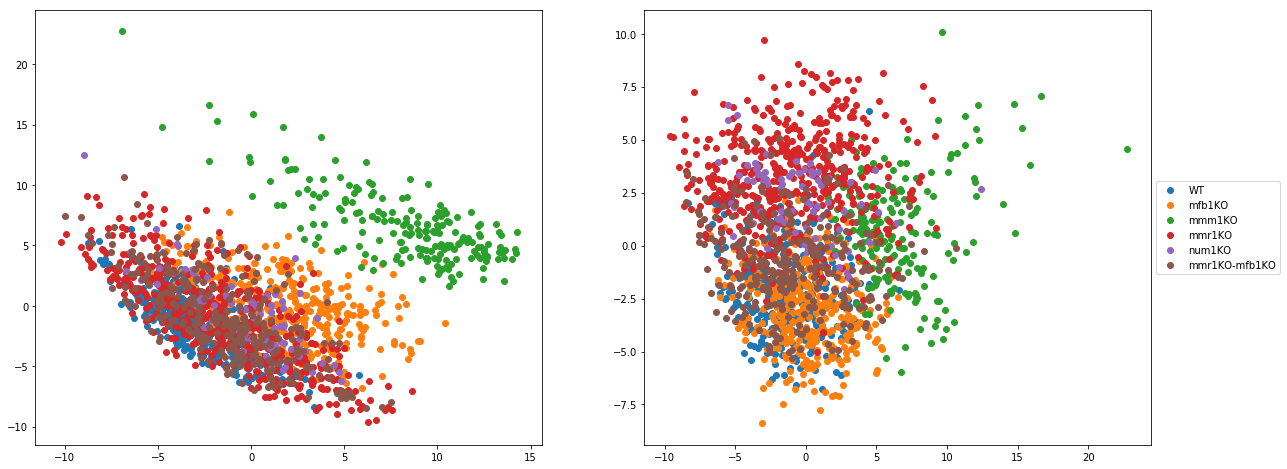

In [41]:
# plotting PCA vs TSNE results

fig, axarr = plt.subplots(1, 2, figsize=(20, 8))

compA = 0
compB = 1

for i in range(6):
    PCA_cls = trn_pca_result[y_trn == i]
    TSNE_cls = tsne_results[y_trn == i]
    
    axarr[0].scatter(PCA_cls[:,compA], PCA_cls[:,compB], label = data.classes[i])
    axarr[1].scatter(TSNE_cls[:,compA], TSNE_cls[:,compB], label = data.classes[i])
    axarr[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))

### Analyse images 

#### Show random correct/incorrectly classified images:

In [ ]:
log_preds_mean = np.mean(log_preds, axis=0) # averages predictions on original + 4 TTA images
preds = np.argmax(log_preds_mean, axis=1) # converts into 0 or 1

In [ ]:
# probs = np.exp(log_preds_mean[:,0]) # prediction(WT)
probs = np.exp(log_preds_mean) # predictions

In [ ]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], 4, replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

In [ ]:
def plots(ims, channel, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=11)
        if channel is not None: plt.imshow(ims[i,channel,:,:]) 
        else: plt.imshow(np.sum(ims, axis=1)[i,:,:])

In [ ]:
def plot_val_with_title_from_ds_no_denorm(idxs, title, channel=None):
    
    imgs = np.stack(data.val_ds[x][0] for x in idxs) # get images by idx
    corr_lbl = np.stack(data.val_ds[x][1] for x in idxs) # get correct label from data.val_ds by idx
    pred_lbl = np.stack(preds[x] for x in idxs) # get predicted label from preds by idx
    p_max = [np.amax(probs[x,:]) for x in idxs] # get highes probability from probs by idx
    
    title_fin = [f"true = {corr_lbl[x]}\n predicted: {pred_lbl[x]}\n  p = {p_max[x]}" for x in corr_lbl]
    print(title)
    
    return plots(imgs, channel, rows=1, titles=title_fin, figsize=(16,8))

### Plot images according to predictions

In [ ]:
# load from ds - not denormalized! 
plot_val_with_title_from_ds_no_denorm(rand_by_correct(True), "Correctly classified")
#optionally pass channel arg. to select single channel

In [ ]:
plot_val_with_title_from_ds_no_denorm(rand_by_correct(False), "Incorrectly classified")

#### Show most correct/incorrectly classified images per class:

In [ ]:
def most_by_mask(mask, y, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[:,y][idxs])[:4]]

def most_by_correct(y, is_correct): 
    mult = -1 if is_correct else 1
    return most_by_mask(((preds == data.val_y)==is_correct) & (data.val_y == y), y, mult)

In [ ]:
plot_val_with_title_from_ds_no_denorm(most_by_correct(0, True), "Most correctly classified WT")

In [ ]:
plot_val_with_title_from_ds_no_denorm(most_by_correct(0, False), "Most incorrectly classified WT") # logic?

In [ ]:
plot_val_with_title_from_ds_no_denorm(most_by_correct(1, True), "Most correctly classified mfb1KO") 

In [ ]:
plot_val_with_title_from_ds_no_denorm(most_by_correct(1, False), "Most incorrectly classified mfb1KO")

In [ ]:
plot_val_with_title_from_ds_no_denorm(most_by_correct(2, True), "Most correctly classified mfb1KO-mmr1KO")

In [ ]:
plot_val_with_title_from_ds_no_denorm(most_by_correct(3, True), "Most correctly classified mmr1KO")

In [ ]:
# etc.

#### Show (most) uncertain images

In [ ]:
most_uncertain = t = np.argsort(np.amax(probs, axis = 1))[:6] # get best "guess" per image and list the least confident ones
plot_val_with_title_from_ds_no_denorm(most_uncertain, "Most uncertain predictions")